# FRANCOIS LARUELLE'S 'DICTIONARY OF NON-PHILOSOPHY' 
## Notebook1: 
## Deriving and plotting the directed graph of references among dictionary items
## By Moses Boudourides & Benjamin Pang

In [1]:
import codecs,re, math, random, pickle, collections, operator, string #,urllib2 
import itertools as it
import pandas as pd
import numpy as np
import networkx as nx
import community
from networkx import NetworkXNoPath
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import graphviz_layout
import json
from networkx.readwrite import json_graph
import pygraphviz
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib._color_data as mcd
import matplotlib.patches as mpatch
from matplotlib import colors as mcolors
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag
from textblob import TextBlob
from wordcloud import WordCloud
import warnings
from IPython.core.display import display, HTML
from string import Template
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning) 

tableau_cl=[c[4:] for c in mcolors.TABLEAU_COLORS] #10 colors
xkcd_cl=[c for c in list({name for name in mcd.CSS4_COLORS
         if "xkcd:" + name in mcd.XKCD_COLORS}) if c!="navy"] #48 colors

In [2]:
scripts = '''
<script src='https://cdnjs.cloudflare.com/ajax/libs/sigma.js/1.2.1/sigma.min.js'></script>
<script src='https://cdnjs.cloudflare.com/ajax/libs/sigma.js/1.2.1/plugins/sigma.plugins.relativeSize.min.js'></script>
<script>
sigmas = {}
;(function(undefined) {

  sigma.canvas.labels.def = function(node, context, settings) {
    var fontSize,
        prefix = settings('prefix') || '',
        size = node[prefix + 'size'],
        labelWidth = 0,
        labelPlacementX,
        labelPlacementY,
        alignment;

    if (size < settings('labelThreshold'))
      return;

    if (typeof node.label !== 'string')
      return;

    if (settings('labelAlignment') === undefined){ 
      alignment = settings('defaultLabelAlignment');
    } else {
      alignment = settings('labelAlignment');
    }

    fontSize = (settings('labelSize') === 'fixed') ?
      settings('defaultLabelSize') :
      settings('labelSizeRatio') * size;

    context.font = (settings('fontStyle') ? settings('fontStyle') + ' ' : '') +
      fontSize + 'px ' + settings('font');
    context.fillStyle = (settings('labelColor') === 'node') ?
      (node.color || settings('defaultNodeColor')) :
      settings('defaultLabelColor');

    labelWidth = context.measureText(node.label).width;
    labelPlacementX = Math.round(node[prefix + 'x'] + size + 3);
    labelPlacementY = Math.round(node[prefix + 'y'] + fontSize / 3);

    switch (alignment) {
      case 'inside':
        if (labelWidth <= size * 2){
          labelPlacementX = Math.round(node[prefix + 'x'] - labelWidth / 2 );
        }
        break;
      case 'center':
        labelPlacementX = Math.round(node[prefix + 'x'] - labelWidth / 2 );
        break;
      case 'left':
        labelPlacementX = Math.round(node[prefix + 'x'] - size - labelWidth - 3 );
        break;
      case 'right':
        labelPlacementX = Math.round(node[prefix + 'x'] + size + 3);
        break;
      case 'top':
        labelPlacementX = Math.round(node[prefix + 'x'] - labelWidth / 2 );
        labelPlacementY = labelPlacementY - size - fontSize;
        break;
      case 'bottom':
        labelPlacementX = Math.round(node[prefix + 'x'] - labelWidth / 2 );
        labelPlacementY = labelPlacementY + size + fontSize;
        break;
      default:
        // Default is aligned 'right'
        labelPlacementX = Math.round(node[prefix + 'x'] + size + 3);
        break;
    }

    context.fillText(
      node.label,
      labelPlacementX,
      labelPlacementY
    );
  };
  
}).call(this)
</script>
'''
HTML(scripts)

In [3]:
def g_diagnostics(G,st):
    
    print("The %s graph has %i nodes and %i edges" %(st,len(G.nodes()), len(G.edges())))
#     print

    if G.is_multigraph()==True:
        print("The %s graph is a multigraph" %st)
    else:
        print("The %s graph is a simple graph" %st)
    if nx.is_weighted(G)==True:
        print("The %s graph is a weighted graph" %st)
    else:
        print("The %s graph is an unweighted graph" %st)
    if G.is_directed()==True:
        print("The %s graph is a directed graph" %st)
    else:
        print("The %s graph is an undirected graph" %st)    
    if nx.is_bipartite(G)==True:
        print("The %s graph is a bipartite graph" %st)
    else:
        print("The %s graph is not a bipartite graph" %st)    
    if nx.is_tree(G)==True:
        print("The %s graph is a tree" %st)
    else:
        print("The %s graph is not a tree" %st)    
    if G.is_directed()==False:
        if nx.is_connected(G)==True:
            print("The %s graph is a connected graph" %st)
        else:
            print("The %s graph is a disconnected graph and it has %i connected components" %(st,nx.number_connected_components(G)))   
    else:
        if nx.is_strongly_connected(G)==True:
            print("The %s graph is a strongly connected graph" %st)
        else:
            print("The %s graph is not strongly connected and it has %i strongly connected components" %(st,nx.number_strongly_connected_components(G)))
        if nx.is_weakly_connected(G)==True:
            print("The %s graph is a weakly connected graph" %st)
        else:
            print("The %s graph is not weakly connected and it has %i weakly connected components" %(st,nx.number_weakly_connected_components(G)))    
    if len(list(nx.isolates(G)))>0:
        print("The %s graph has isolates" %(st,len(list(nx.isolates(G)))))
    else:
        print("The %s graph has no isolates" %st)
    print("The density of the %s graph is %.3f" %(st,nx.density(G)))   
    print("The transitivity of the %s graph is %.3f" %(st,nx.transitivity(G))) 
    print("The reciprocity of the %s graph is %.3f" %(st,nx.reciprocity(G)))

def g_diameter(G,st):    
    try:
        diameter=nx.diameter(G)
        print("The diameter of the largest strongly connected component of %s graph is %i" %(st,diameter))
    except Exception as e: 
        print(e)

### Reading the text of Francois Laruelle's 'Dictionary of Non-Philosophy'

In [4]:
filename = 'laruelle_francois_dictionary_of_non-philosophy_CLEANED_V3.txt'
titlename="Laruelle's 'Dictionary of Non-Philosophy'"

f = codecs.open(filename, "r", encoding="utf-8").readlines()

num_lines = 0
num_words = 0
num_chars = 0
for line in f:
    words = line.split()
    num_lines += 1
    num_words += len(words)
    num_chars += len(line)
print("%s has number of words = %i (and number of characters/symbols = %i)" %(titlename,num_words,num_chars))

Laruelle's 'Dictionary of Non-Philosophy' has number of words = 44055 (and number of characters/symbols = 296477)


In [5]:
items_d={}
text="\n".join(f).split("#")
text=[s.replace('\r','') for s in text if len(s)>0]
for t in text:
    tt=t.split('\n')
    tt=[s for s in tt if len(s)>0]
    items_d[tt[0].strip().lower()]=' '.join(tt[1:]).strip().lower()

In [6]:
print(len(items_d))
sorted(items_d.keys())

70


['(non-)one',
 'auto-position',
 'being-in-one',
 'break',
 'chora',
 'definition',
 'democracy',
 'desire',
 'determination-in-the-last-instance',
 'distance',
 'drive',
 'dual',
 'europanalysis',
 'experimentation',
 'first name',
 'force (of) thought',
 'formal ontology',
 'fractality',
 'generalization',
 'given-without-givenness',
 'god-without-being',
 'human',
 'hypothesis',
 'lived experience',
 'material ontology',
 'metascience',
 'mixture',
 'multiple',
 'mystique',
 'non-aesthetics',
 'non-autopositional presentation',
 'non-dictionary',
 'non-epistemology',
 'non-erotics',
 'non-ethics',
 'non-intuitive',
 'non-philosophy',
 'non-psychoanalysis',
 'non-rhetoric',
 'non-sufficiency',
 'non-technology',
 'occasion',
 'other*',
 'performativity',
 'philosophical decision',
 'philosophy',
 'primacy',
 'priority-without-primacy',
 'radical immanence',
 'rea*l essence',
 'real',
 'reflection',
 'relative autonomy',
 'reversibility',
 'rule',
 'science',
 'science-of-men',
 'soli

In [7]:
for k,v in items_d.items():
    print(list(items_d.keys()).index(k)+1, '|', k, '|', v)
    print("\n &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& \n")

1 | auto-position | the highest formal act of the philosophical decision through which philosophical faith in the real enables the latter to be posited as the real in an illusory way. it is consequently the real cause of the appearance of philosophy. auto-position as real of the transcendental unity proper to philosophy is that which prioritizes the vision-in-one. the formal trait of auto-position is structural and completely exceeds the presence of this concept in fichte (self=self). not only the transcendental one—the peak of philosophical knowledge—but whichever concept (cf. deleuze) is itself posited or is in a state of pairing, doubling, self-survey…philosophizing is concentrated in the inasmuch and the as [l’en tant que et le comme], in the repetition of a more or less differentiated same. this trait forms a system with philosophy’s no less structural debt to perception as its point of departure and to transcending it as its essential organon. object and objectivity, phenomenolog

In [8]:
textt=" ".join(text)
ditems=sorted(items_d.keys())
freqs=[]
for di in ditems:
    freqs.append(textt.count(di))
dif_df = pd.DataFrame(
    {'dictionary_item': ditems, 
     'frequency': freqs
    })
dif_df=dif_df[['dictionary_item','frequency']]
print(len(dif_df))
dif_df.sort_values('frequency',ascending=False)

70


,dictionary_item,frequency
45,philosophy,624
50,real,376
59,thought,366
55,science,238
64,transcendental,216
...,...,...
40,non-technology,1
30,non-autopositional presentation,1
32,non-epistemology,1
33,non-erotics,1


In [9]:
records = dif_df. to_records(index=False)
records=sorted(records, key=lambda x: x[1],reverse=True)
records

[('philosophy', 624),
 ('real', 376),
 ('thought', 366),
 ('science', 238),
 ('transcendental', 216),
 ('world', 190),
 ('non-philosophy', 146),
 ('other*', 101),
 ('force (of) thought', 89),
 ('occasion', 85),
 ('stranger', 83),
 ('mixture', 82),
 ('dual', 80),
 ('reflection', 55),
 ('desire', 53),
 ('philosophical decision', 53),
 ('multiple', 50),
 ('human', 49),
 ('primacy', 44),
 ('rule', 44),
 ('thought-worl*d', 44),
 ('definition', 40),
 ('unconscious', 36),
 ('distance', 32),
 ('break', 28),
 ('universality', 24),
 ('given-without-givenness', 20),
 ('radical immanence', 20),
 ('solitude', 18),
 ('democracy', 16),
 ('reversibility', 16),
 ('determination-in-the-last-instance', 15),
 ('generalization', 15),
 ('hypothesis', 15),
 ('experimentation', 14),
 ('metascience', 14),
 ('relative autonomy', 13),
 ('chora', 12),
 ('first name', 12),
 ('rea*l essence', 12),
 ('drive', 11),
 ('lived experience', 11),
 ('auto-position', 10),
 ('performativity', 10),
 ('transcendenta*l science'

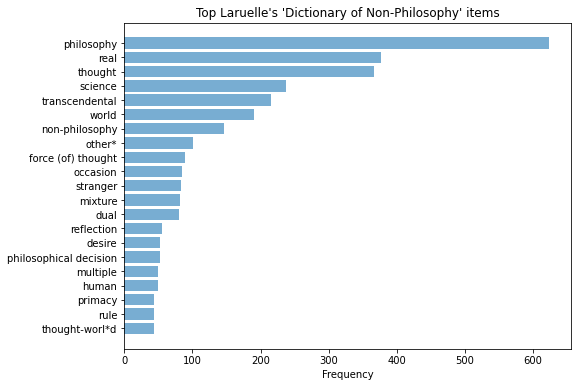

In [10]:
keys = [i for (i,j) in records if j>40] 
y_pos = range(len(keys)) #np.arange(len(keys))
performance = [j for (i,j) in records if j>40] 
plt.figure(figsize=(8,6))
ax = plt.axes()
plt.barh(y_pos, performance, align='center', alpha=0.6) 
ax.invert_yaxis()
plt.yticks(y_pos, keys)
plt.xlabel('Frequency' )
sst="Top %s items" %titlename
plt.title(sst)
plt.show()

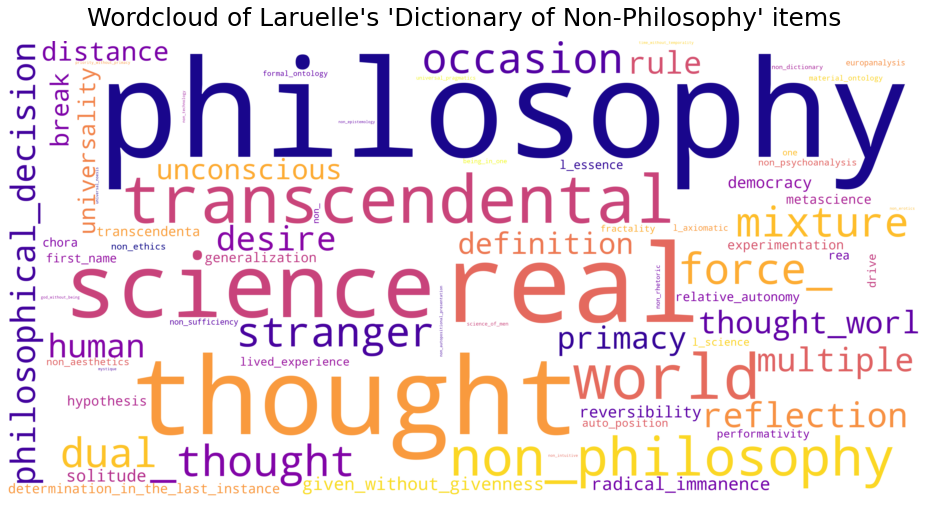

In [11]:
subsetd = dif_df[['dictionary_item','frequency']]
tuplesd = [tuple(x) for x in subsetd.values]

t=[]
for (i,j) in tuplesd:
    for k in range(j):
#         print(i.replace(" ","_").replace("-","_"))
        t.append(i.replace(" ","_").replace("-","_"))
ttd=' '.join(t)

wordcloud = WordCloud(collocations=False,background_color="white",colormap="plasma",width=4000,height=2000).generate(ttd)
fig = plt.figure(figsize=(13,13))
default_colors = wordcloud.to_array()
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
ss="Wordcloud of %s items" %titlename
plt.suptitle(ss,fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 1.4]) 
plt.show()

### The directed of references among Laruelle's dictionary items

In [12]:
edges=[]
for k,v in items_d.items():
    for kk in items_d.keys():
        if kk!=k:
            if kk in v:
                edges.append((k,kk))
print(len(edges))

864


In [13]:
G0=nx.DiGraph()
G0.add_edges_from(edges)
print(len(G0), len(G0.edges()))

70 864


In [14]:
st=titlename
g_diagnostics(G0,st)

The Laruelle's 'Dictionary of Non-Philosophy' graph has 70 nodes and 864 edges
The Laruelle's 'Dictionary of Non-Philosophy' graph is a simple graph
The Laruelle's 'Dictionary of Non-Philosophy' graph is an unweighted graph
The Laruelle's 'Dictionary of Non-Philosophy' graph is a directed graph
The Laruelle's 'Dictionary of Non-Philosophy' graph is not a bipartite graph
The Laruelle's 'Dictionary of Non-Philosophy' graph is not a tree
The Laruelle's 'Dictionary of Non-Philosophy' graph is not strongly connected and it has 19 strongly connected components
The Laruelle's 'Dictionary of Non-Philosophy' graph is a weakly connected graph
The Laruelle's 'Dictionary of Non-Philosophy' graph has no isolates
The density of the Laruelle's 'Dictionary of Non-Philosophy' graph is 0.179
The transitivity of the Laruelle's 'Dictionary of Non-Philosophy' graph is 0.533
The reciprocity of the Laruelle's 'Dictionary of Non-Philosophy' graph is 0.227


In [15]:
mapping = {
    'other*': 'Other',
    'rea*l essence': 'real essence',
    'thought-worl*d': 'thought-world',
    'transcendenta*l axiomatic': 'transcendental axiomatic',
    'transcendenta*l science': 'transcendental science'
}

G = nx.relabel_nodes(G0, mapping)
print(len(G.nodes()), len(G.edges()))

70 864


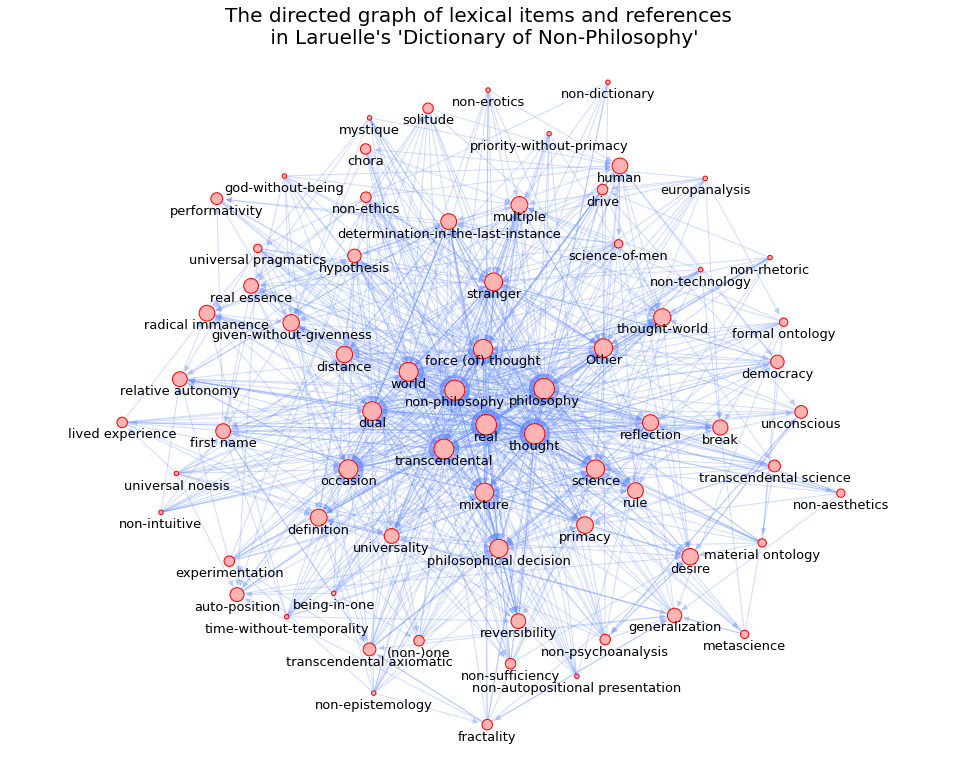

In [16]:
# nsi=[100*math.log(1+G.in_degree(n)) for n in G.nodes()]
nsi=[]
for n in G.nodes():
    if G.in_degree(n)>0:
        nsi.append(100*math.log(1+G.in_degree(n)))
    else:
        nsi.append(20)
figsize=(17,13)
pos=graphviz_layout(G)

def adjust(a, t):
    for i, p in t.items():
        a[i] = a[i][0] + p[0], a[i][1] + p[1]

tweaks = {
    'thought': (5, -5),
    'real': (0, -5),
    'philosophy': (13, 0),
    'non-ethics': (0, 10),
    'determination-in-the-last-instance': (0, 5),
    'non-rhetoric': (0, 5),
    'distance': (0, -10),
    'given-without-givenness': (5, 0),
    'non-sufficiency': (0, 5),
    'generalization': (5, 5),
    'non-psychoanalysis': (0, -5),
    'transcendental science': (0, 7),
    'philosophical decision': (0, -5),
    'performativity': (0, -5),
}

adjust(pos, tweaks)
pos_data = pos

node_color="#ffb3b3"
node_border_color="r"
edge_color="#668cff"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,arrowsize=12, edge_color=edge_color,alpha=0.3)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -4 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset,font_size=13);
sst="The directed graph of lexical items and references \n in %s" %st
plt.title(sst,fontsize=20);
plt.margins(x=0.1, y=0) 

In [17]:
graph_data = json_graph.node_link_data(G)
print(graph_data)

{'directed': True, 'multigraph': False, 'graph': {}, 'nodes': [{'id': 'auto-position'}, {'id': 'desire'}, {'id': 'dual'}, {'id': 'occasion'}, {'id': 'philosophical decision'}, {'id': 'philosophy'}, {'id': 'real'}, {'id': 'thought'}, {'id': 'transcendental'}, {'id': 'being-in-one'}, {'id': 'distance'}, {'id': 'science'}, {'id': 'force (of) thought'}, {'id': 'multiple'}, {'id': '(non-)one'}, {'id': 'non-philosophy'}, {'id': 'Other'}, {'id': 'primacy'}, {'id': 'break'}, {'id': 'chora'}, {'id': 'given-without-givenness'}, {'id': 'mixture'}, {'id': 'world'}, {'id': 'definition'}, {'id': 'generalization'}, {'id': 'rule'}, {'id': 'transcendental axiomatic'}, {'id': 'democracy'}, {'id': 'human'}, {'id': 'reflection'}, {'id': 'stranger'}, {'id': 'thought-world'}, {'id': 'non-psychoanalysis'}, {'id': 'unconscious'}, {'id': 'determination-in-the-last-instance'}, {'id': 'performativity'}, {'id': 'radical immanence'}, {'id': 'relative autonomy'}, {'id': 'reversibility'}, {'id': 'drive'}, {'id': 'un

In [18]:
js_template = Template('''
sigmas.$order = new sigma({
  renderer: {
    container: 'container$order',
    type: 'canvas'
  },
  settings: {
    minArrowSize: 10,
    labelThreshold: 1,
    defaultLabelAlignment: 'bottom'
  }
})

bind = S=>{
  let graph = $graph_data
  let pos = $pos_data
  
  let get_neighbors = (id, g)=>{
    let res = {}
    g.nodes().map(n=>{
      if(g.edges().find(e=> ~[e.source, e.target].indexOf(n.id) && ~[e.source, e.target].indexOf(id))){
        res[n.id] = n
      }
    })
    return res
  }

  graph.nodes.map((a, i)=>{
    a.label = a.id
    a.x = pos[a.id][0]
    a.y = pos[a.id][1]
    a.color = '$node_color'
    S.graph.addNode(a)
  })

  graph.links.map((a, i)=>{
    a.id = i
    a.type = '$edge_type'
    a.color = '$edge_color'
    S.graph.addEdge(a)
  })

  sigma.plugins.relativeSize(S, 1)

  S.bind('clickNode', e=>{
    let id = e.data.node.id
    let keep = get_neighbors(id, S.graph)
    keep[id] = e.data.node
  
    S.graph.nodes().forEach(n=>{
      n.color = keep[n.id] ? '$node_color' : '#eee'
    })
  
    S.graph.edges().forEach(e=>{
      e.color = keep[e.source] && keep[e.target] ? '$edge_color' : 'rgba(238, 238, 238, .3)'
    })
  
    S.refresh()
  })

  S.bind('clickStage', e=>{
    if(!e.data.captor.isDragging){
      S.graph.nodes().forEach(n=>{
        n.color = '$node_color'
      })

      S.graph.edges().forEach(e=>{
        e.color = '$edge_color'
      })

      S.refresh()
    }
  })

  S.refresh()
}

bind(sigmas.$order)
''')

html_template = Template('''
<h1 style='font-family:sans-serif;text-align:center'>$title</h1>
<br>
<div id='container$order' style='height:800px'></div>
<script>$js_text</script>
''')

def htor(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

In [19]:
order = 'dir'
js_text = js_template.substitute({
    'order': order,
    'graph_data': json.dumps(graph_data),
    'pos_data': json.dumps(pos),
    'edge_type': 'arrow',
    'node_color': node_color,
    'edge_color': 'rgba(%d, %d, %d, .5)' % htor(edge_color)
})

html_text = html_template.substitute({
    'order': order,
    'title': sst,
    'js_text': js_text
})

HTML(html_text)

In [20]:
f = open('graph%s.html' % order, 'w+')
f.write(scripts + html_text)
f.close()

#### The largest strongly connected component

In [21]:
Gl = max(nx.strongly_connected_components(G), key=len)
Glcc=G.subgraph(Gl)
print(len(Glcc), len(Glcc.edges()))

52 642


In [22]:
st1 = "Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy'"
g_diagnostics(Glcc,st1)

The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph has 52 nodes and 642 edges
The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is a simple graph
The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is an unweighted graph
The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is a directed graph
The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is not a bipartite graph
The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is not a tree
The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is a strongly connected graph
The Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is a weakly connected graph
The Lar

#### Nodes outside the largest strongly connected component

In [23]:
for n in G.nodes():
    if n not in Glcc.nodes():
        print(n)
        print(list(G.successors(n)))
        print(list(G.predecessors(n)))
        print("&&&&&&&&&&&&&&&&&&&&&&")

being-in-one
['auto-position', 'distance', 'dual', 'science', 'force (of) thought', 'multiple', '(non-)one', 'non-philosophy', 'Other', 'philosophy', 'primacy', 'real', 'thought', 'transcendental']
[]
&&&&&&&&&&&&&&&&&&&&&&
drive
['force (of) thought', 'given-without-givenness', 'non-philosophy', 'Other', 'philosophy', 'radical immanence', 'real', 'thought', 'thought-world', 'transcendental', 'unconscious', 'universality', 'world']
['europanalysis', 'non-rhetoric']
&&&&&&&&&&&&&&&&&&&&&&
europanalysis
['break', 'chora', 'drive', 'dual', 'science', 'formal ontology', 'hypothesis', 'multiple', 'non-philosophy', 'Other', 'philosophy', 'real', 'thought']
[]
&&&&&&&&&&&&&&&&&&&&&&
formal ontology
['break', 'determination-in-the-last-instance', 'force (of) thought', 'generalization', 'material ontology', 'multiple', 'non-philosophy', 'Other', 'philosophical decision', 'philosophy', 'real', 'thought', 'transcendental']
['europanalysis']
&&&&&&&&&&&&&&&&&&&&&&
material ontology
['democracy', '

In [24]:
g_diameter(Glcc,st)

The diameter of the largest strongly connected component of Laruelle's 'Dictionary of Non-Philosophy' graph is 5


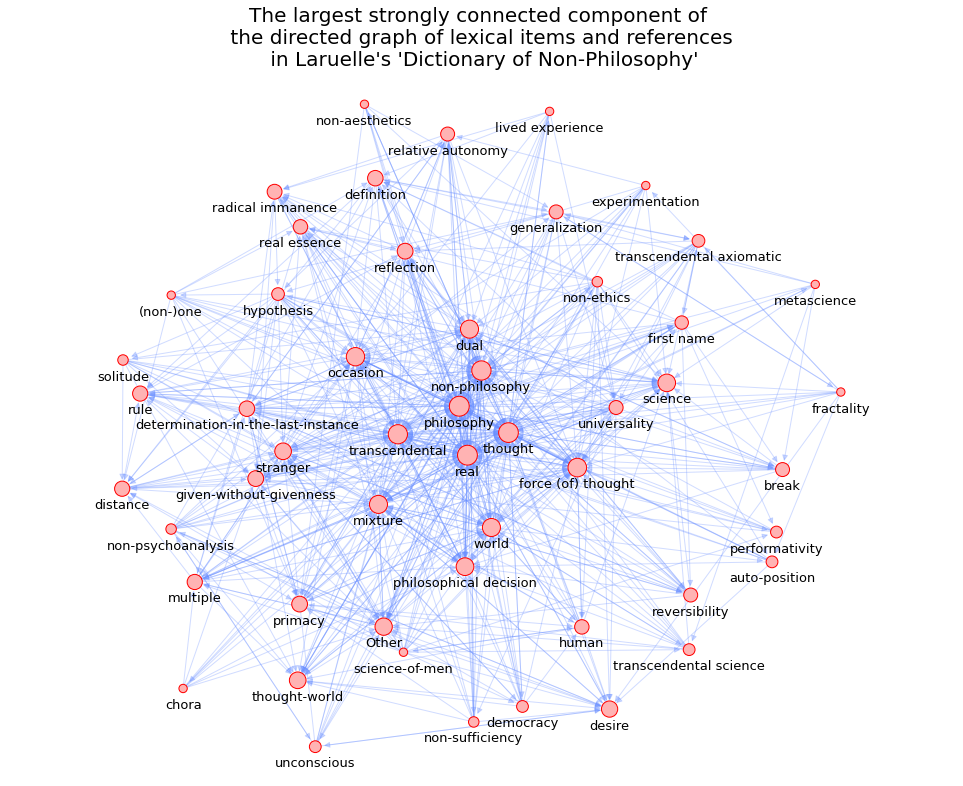

In [25]:
# nsi=[100*math.log(1+G.in_degree(n)) for n in G.nodes()]
nsi=[]
for n in Glcc.nodes():
    if Glcc.in_degree(n)>0:
        nsi.append(100*math.log(1+Glcc.in_degree(n)))
    else:
        nsi.append(20)
figsize=(17,13)
pos=graphviz_layout(Glcc) 

tweaks = {
    'philosophy': (0, 5),
    'democracy': (0, 5),
    'rule': (0, -5),
}

adjust(pos, tweaks)

node_color="#ffb3b3"
node_border_color="r"
edge_color="#668cff"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Glcc, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Glcc, pos,arrowsize=12, edge_color=edge_color,alpha=0.3)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Glcc, yoffset,font_size=13);
sst="The largest strongly connected component of \n the directed graph of lexical items and references \n in %s" %st
plt.title(sst,fontsize=20);
plt.margins(x=0.1, y=0) 

In [26]:
graph_data = json_graph.node_link_data(Glcc)

In [27]:
# order = 'lcc'
# js_text = js_template.substitute({
#     'order': order,
#     'graph_data': json.dumps(graph_data),
#     'pos_data': json.dumps(pos),
#     'edge_type': 'arrow',
#     'arrowsize': 10,
#     'node_color': node_color,
#     'edge_color': 'rgba(%d, %d, %d, .5)' % htor(edge_color)
# })
# html_text = html_template.substitute({
#     'order': order,
#     'title': sst,
#     'js_text': js_text
# })

# HTML(html_text)

In [28]:
# f = open('graph%s.html' % order, 'w+')
# f.write(scripts + html_text)
# f.close()

### Directed paths between nodes of the largest strongly connected component

In [29]:
node1="philosophical decision"
node2="performativity"

try:
    ii = nx.dijkstra_path(G,node1,node2)
    nnd=[(ii[i],ii[i+1]) for i in range(len(ii)-1)]
except e: #NetworkXNoPath,e:
    print(e)
    ii=[]
    nnd=[]
print("The directed path from '%s' to '%s' is:" %(node1,node2))
print(ii)
print("The distance between '%s' and '%s' in %i" %(node1,node2,len(ii)-1))
# nnd=[]
# nnd

The directed path from 'philosophical decision' to 'performativity' is:
['philosophical decision', 'dual', 'determination-in-the-last-instance', 'performativity']
The distance between 'philosophical decision' and 'performativity' in 3


In [30]:
paths = {}
for node1 in Glcc.nodes():
    paths[node1] = {}
    for node2 in Glcc.nodes():
        if node1 != node2:
            try:
                ii = nx.dijkstra_path(Glcc,node1,node2)
                nnd=[(ii[i],ii[i+1]) for i in range(len(ii)-1)]
            except e: # NetworkXNoPath,e:
                print(e)
                ii=[]
                nnd=[]
            paths[node1][node2] = ii
            print("The directed path from '%s' to '%s' is:" %(node1,node2))
            print(ii)
            print("The distance between '%s' and '%s' in %i" %(node1,node2,len(ii)-1))
            print("")

The directed path from 'auto-position' to 'desire' is:
['auto-position', 'desire']
The distance between 'auto-position' and 'desire' in 1

The directed path from 'auto-position' to 'dual' is:
['auto-position', 'dual']
The distance between 'auto-position' and 'dual' in 1

The directed path from 'auto-position' to 'occasion' is:
['auto-position', 'occasion']
The distance between 'auto-position' and 'occasion' in 1

The directed path from 'auto-position' to 'philosophical decision' is:
['auto-position', 'philosophical decision']
The distance between 'auto-position' and 'philosophical decision' in 1

The directed path from 'auto-position' to 'philosophy' is:
['auto-position', 'philosophy']
The distance between 'auto-position' and 'philosophy' in 1

The directed path from 'auto-position' to 'real' is:
['auto-position', 'real']
The distance between 'auto-position' and 'real' in 1

The directed path from 'auto-position' to 'thought' is:
['auto-position', 'thought']
The distance between 'auto-

['occasion', 'relative autonomy', 'hypothesis', '(non-)one']
The distance between 'occasion' and '(non-)one' in 3

The directed path from 'occasion' to 'non-philosophy' is:
['occasion', 'non-philosophy']
The distance between 'occasion' and 'non-philosophy' in 1

The directed path from 'occasion' to 'Other' is:
['occasion', 'Other']
The distance between 'occasion' and 'Other' in 1

The directed path from 'occasion' to 'primacy' is:
['occasion', 'determination-in-the-last-instance', 'primacy']
The distance between 'occasion' and 'primacy' in 2

The directed path from 'occasion' to 'break' is:
['occasion', 'philosophy', 'break']
The distance between 'occasion' and 'break' in 2

The directed path from 'occasion' to 'chora' is:
['occasion', 'non-philosophy', 'chora']
The distance between 'occasion' and 'chora' in 2

The directed path from 'occasion' to 'given-without-givenness' is:
['occasion', 'thought', 'given-without-givenness']
The distance between 'occasion' and 'given-without-givennes

The directed path from 'real' to 'relative autonomy' is:
['real', 'relative autonomy']
The distance between 'real' and 'relative autonomy' in 1

The directed path from 'real' to 'reversibility' is:
['real', 'thought', 'reversibility']
The distance between 'real' and 'reversibility' in 2

The directed path from 'real' to 'universality' is:
['real', 'definition', 'generalization', 'universality']
The distance between 'real' and 'universality' in 3

The directed path from 'real' to 'non-sufficiency' is:
['real', 'definition', 'dual', 'non-sufficiency']
The distance between 'real' and 'non-sufficiency' in 3

The directed path from 'real' to 'hypothesis' is:
['real', 'radical immanence', 'hypothesis']
The distance between 'real' and 'hypothesis' in 2

The directed path from 'real' to 'experimentation' is:
['real', 'definition', 'generalization', 'fractality', 'experimentation']
The distance between 'real' and 'experimentation' in 4

The directed path from 'real' to 'first name' is:
['real',

The directed path from 'distance' to 'transcendental science' is:
['distance', 'determination-in-the-last-instance', 'world', 'transcendental science']
The distance between 'distance' and 'transcendental science' in 3

The directed path from 'distance' to 'non-aesthetics' is:
['distance', 'determination-in-the-last-instance', 'non-philosophy', 'non-aesthetics']
The distance between 'distance' and 'non-aesthetics' in 3

The directed path from 'distance' to 'non-ethics' is:
['distance', 'determination-in-the-last-instance', 'non-philosophy', 'non-ethics']
The distance between 'distance' and 'non-ethics' in 3

The directed path from 'science' to 'auto-position' is:
['science', 'force (of) thought', 'world', 'auto-position']
The distance between 'science' and 'auto-position' in 3

The directed path from 'science' to 'desire' is:
['science', 'mixture', 'desire']
The distance between 'science' and 'desire' in 2

The directed path from 'science' to 'dual' is:
['science', 'force (of) thought',

The directed path from 'force (of) thought' to 'solitude' is:
['force (of) thought', 'non-philosophy', 'non-ethics', 'solitude']
The distance between 'force (of) thought' and 'solitude' in 3

The directed path from 'force (of) thought' to 'lived experience' is:
['force (of) thought', 'thought', 'lived experience']
The distance between 'force (of) thought' and 'lived experience' in 2

The directed path from 'force (of) thought' to 'science-of-men' is:
['force (of) thought', 'human', 'science-of-men']
The distance between 'force (of) thought' and 'science-of-men' in 2

The directed path from 'force (of) thought' to 'metascience' is:
['force (of) thought', 'thought', 'metascience']
The distance between 'force (of) thought' and 'metascience' in 2

The directed path from 'force (of) thought' to 'transcendental science' is:
['force (of) thought', 'world', 'transcendental science']
The distance between 'force (of) thought' and 'transcendental science' in 2

The directed path from 'force (of) 

The distance between 'non-philosophy' and 'force (of) thought' in 1

The directed path from 'non-philosophy' to 'multiple' is:
['non-philosophy', 'multiple']
The distance between 'non-philosophy' and 'multiple' in 1

The directed path from 'non-philosophy' to '(non-)one' is:
['non-philosophy', 'science', 'hypothesis', '(non-)one']
The distance between 'non-philosophy' and '(non-)one' in 3

The directed path from 'non-philosophy' to 'Other' is:
['non-philosophy', 'Other']
The distance between 'non-philosophy' and 'Other' in 1

The directed path from 'non-philosophy' to 'primacy' is:
['non-philosophy', 'non-aesthetics', 'primacy']
The distance between 'non-philosophy' and 'primacy' in 2

The directed path from 'non-philosophy' to 'break' is:
['non-philosophy', 'dual', 'break']
The distance between 'non-philosophy' and 'break' in 2

The directed path from 'non-philosophy' to 'chora' is:
['non-philosophy', 'chora']
The distance between 'non-philosophy' and 'chora' in 1

The directed path f


The directed path from 'primacy' to 'thought-world' is:
['primacy', 'democracy', 'thought-world']
The distance between 'primacy' and 'thought-world' in 2

The directed path from 'primacy' to 'non-psychoanalysis' is:
['primacy', 'desire', 'non-psychoanalysis']
The distance between 'primacy' and 'non-psychoanalysis' in 2

The directed path from 'primacy' to 'unconscious' is:
['primacy', 'desire', 'unconscious']
The distance between 'primacy' and 'unconscious' in 2

The directed path from 'primacy' to 'determination-in-the-last-instance' is:
['primacy', 'determination-in-the-last-instance']
The distance between 'primacy' and 'determination-in-the-last-instance' in 1

The directed path from 'primacy' to 'performativity' is:
['primacy', 'determination-in-the-last-instance', 'performativity']
The distance between 'primacy' and 'performativity' in 2

The directed path from 'primacy' to 'radical immanence' is:
['primacy', 'determination-in-the-last-instance', 'radical immanence']
The distance


The directed path from 'given-without-givenness' to 'primacy' is:
['given-without-givenness', 'primacy']
The distance between 'given-without-givenness' and 'primacy' in 1

The directed path from 'given-without-givenness' to 'break' is:
['given-without-givenness', 'dual', 'break']
The distance between 'given-without-givenness' and 'break' in 2

The directed path from 'given-without-givenness' to 'chora' is:
['given-without-givenness', 'non-philosophy', 'chora']
The distance between 'given-without-givenness' and 'chora' in 2

The directed path from 'given-without-givenness' to 'mixture' is:
['given-without-givenness', 'dual', 'mixture']
The distance between 'given-without-givenness' and 'mixture' in 2

The directed path from 'given-without-givenness' to 'world' is:
['given-without-givenness', 'world']
The distance between 'given-without-givenness' and 'world' in 1

The directed path from 'given-without-givenness' to 'definition' is:
['given-without-givenness', 'first name', 'definition'

The directed path from 'definition' to 'real essence' is:
['definition', 'distance', 'force (of) thought', 'real essence']
The distance between 'definition' and 'real essence' in 3

The directed path from 'definition' to 'fractality' is:
['definition', 'generalization', 'fractality']
The distance between 'definition' and 'fractality' in 2

The directed path from 'definition' to 'solitude' is:
['definition', 'non-philosophy', 'non-ethics', 'solitude']
The distance between 'definition' and 'solitude' in 3

The directed path from 'definition' to 'lived experience' is:
['definition', 'distance', 'thought', 'lived experience']
The distance between 'definition' and 'lived experience' in 3

The directed path from 'definition' to 'science-of-men' is:
['definition', 'distance', 'force (of) thought', 'human', 'science-of-men']
The distance between 'definition' and 'science-of-men' in 4

The directed path from 'definition' to 'metascience' is:
['definition', 'distance', 'thought', 'metascience']


The directed path from 'transcendental axiomatic' to 'solitude' is:
['transcendental axiomatic', 'science', 'hypothesis', 'solitude']
The distance between 'transcendental axiomatic' and 'solitude' in 3

The directed path from 'transcendental axiomatic' to 'lived experience' is:
['transcendental axiomatic', 'thought', 'lived experience']
The distance between 'transcendental axiomatic' and 'lived experience' in 2

The directed path from 'transcendental axiomatic' to 'science-of-men' is:
['transcendental axiomatic', 'force (of) thought', 'human', 'science-of-men']
The distance between 'transcendental axiomatic' and 'science-of-men' in 3

The directed path from 'transcendental axiomatic' to 'metascience' is:
['transcendental axiomatic', 'thought', 'metascience']
The distance between 'transcendental axiomatic' and 'metascience' in 2

The directed path from 'transcendental axiomatic' to 'transcendental science' is:
['transcendental axiomatic', 'world', 'transcendental science']
The distance 

The directed path from 'reflection' to 'transcendental' is:
['reflection', 'transcendental']
The distance between 'reflection' and 'transcendental' in 1

The directed path from 'reflection' to 'distance' is:
['reflection', 'dual', 'break', 'distance']
The distance between 'reflection' and 'distance' in 3

The directed path from 'reflection' to 'science' is:
['reflection', 'dual', 'science']
The distance between 'reflection' and 'science' in 2

The directed path from 'reflection' to 'force (of) thought' is:
['reflection', 'force (of) thought']
The distance between 'reflection' and 'force (of) thought' in 1

The directed path from 'reflection' to 'multiple' is:
['reflection', 'force (of) thought', 'multiple']
The distance between 'reflection' and 'multiple' in 2

The directed path from 'reflection' to '(non-)one' is:
['reflection', 'radical immanence', 'hypothesis', '(non-)one']
The distance between 'reflection' and '(non-)one' in 3

The directed path from 'reflection' to 'non-philosophy

The directed path from 'thought-world' to 'transcendental' is:
['thought-world', 'mixture', 'transcendental']
The distance between 'thought-world' and 'transcendental' in 2

The directed path from 'thought-world' to 'distance' is:
['thought-world', 'Other', 'distance']
The distance between 'thought-world' and 'distance' in 2

The directed path from 'thought-world' to 'science' is:
['thought-world', 'non-philosophy', 'science']
The distance between 'thought-world' and 'science' in 2

The directed path from 'thought-world' to 'force (of) thought' is:
['thought-world', 'mixture', 'force (of) thought']
The distance between 'thought-world' and 'force (of) thought' in 2

The directed path from 'thought-world' to 'multiple' is:
['thought-world', 'mixture', 'multiple']
The distance between 'thought-world' and 'multiple' in 2

The directed path from 'thought-world' to '(non-)one' is:
['thought-world', 'non-philosophy', 'science', 'hypothesis', '(non-)one']
The distance between 'thought-world' a

The directed path from 'unconscious' to 'performativity' is:
['unconscious', 'dual', 'determination-in-the-last-instance', 'performativity']
The distance between 'unconscious' and 'performativity' in 3

The directed path from 'unconscious' to 'radical immanence' is:
['unconscious', 'dual', 'radical immanence']
The distance between 'unconscious' and 'radical immanence' in 2

The directed path from 'unconscious' to 'relative autonomy' is:
['unconscious', 'dual', 'relative autonomy']
The distance between 'unconscious' and 'relative autonomy' in 2

The directed path from 'unconscious' to 'reversibility' is:
['unconscious', 'dual', 'reversibility']
The distance between 'unconscious' and 'reversibility' in 2

The directed path from 'unconscious' to 'universality' is:
['unconscious', 'mixture', 'force (of) thought', 'universality']
The distance between 'unconscious' and 'universality' in 3

The directed path from 'unconscious' to 'non-sufficiency' is:
['unconscious', 'dual', 'non-sufficiency'


The directed path from 'radical immanence' to 'unconscious' is:
['radical immanence', 'thought', 'unconscious']
The distance between 'radical immanence' and 'unconscious' in 2

The directed path from 'radical immanence' to 'determination-in-the-last-instance' is:
['radical immanence', 'philosophy', 'determination-in-the-last-instance']
The distance between 'radical immanence' and 'determination-in-the-last-instance' in 2

The directed path from 'radical immanence' to 'performativity' is:
['radical immanence', 'given-without-givenness', 'first name', 'performativity']
The distance between 'radical immanence' and 'performativity' in 3

The directed path from 'radical immanence' to 'relative autonomy' is:
['radical immanence', 'real', 'relative autonomy']
The distance between 'radical immanence' and 'relative autonomy' in 2

The directed path from 'radical immanence' to 'reversibility' is:
['radical immanence', 'thought', 'reversibility']
The distance between 'radical immanence' and 'rev

The distance between 'universality' and 'non-sufficiency' in 1

The directed path from 'universality' to 'hypothesis' is:
['universality', 'science', 'hypothesis']
The distance between 'universality' and 'hypothesis' in 2

The directed path from 'universality' to 'experimentation' is:
['universality', 'definition', 'generalization', 'fractality', 'experimentation']
The distance between 'universality' and 'experimentation' in 4

The directed path from 'universality' to 'first name' is:
['universality', 'given-without-givenness', 'first name']
The distance between 'universality' and 'first name' in 2

The directed path from 'universality' to 'real essence' is:
['universality', 'force (of) thought', 'real essence']
The distance between 'universality' and 'real essence' in 2

The directed path from 'universality' to 'fractality' is:
['universality', 'definition', 'generalization', 'fractality']
The distance between 'universality' and 'fractality' in 3

The directed path from 'universality'

['experimentation', 'force (of) thought', 'reflection']
The distance between 'experimentation' and 'reflection' in 2

The directed path from 'experimentation' to 'stranger' is:
['experimentation', 'hypothesis', 'stranger']
The distance between 'experimentation' and 'stranger' in 2

The directed path from 'experimentation' to 'thought-world' is:
['experimentation', 'mixture', 'thought-world']
The distance between 'experimentation' and 'thought-world' in 2

The directed path from 'experimentation' to 'non-psychoanalysis' is:
['experimentation', 'mixture', 'desire', 'non-psychoanalysis']
The distance between 'experimentation' and 'non-psychoanalysis' in 3

The directed path from 'experimentation' to 'unconscious' is:
['experimentation', 'thought', 'unconscious']
The distance between 'experimentation' and 'unconscious' in 2

The directed path from 'experimentation' to 'determination-in-the-last-instance' is:
['experimentation', 'dual', 'determination-in-the-last-instance']
The distance bet

The distance between 'real essence' and 'non-sufficiency' in 2

The directed path from 'real essence' to 'hypothesis' is:
['real essence', 'determination-in-the-last-instance', 'science', 'hypothesis']
The distance between 'real essence' and 'hypothesis' in 3

The directed path from 'real essence' to 'experimentation' is:
['real essence', 'non-philosophy', 'non-aesthetics', 'generalization', 'fractality', 'experimentation']
The distance between 'real essence' and 'experimentation' in 5

The directed path from 'real essence' to 'first name' is:
['real essence', 'mixture', 'first name']
The distance between 'real essence' and 'first name' in 2

The directed path from 'real essence' to 'fractality' is:
['real essence', 'non-philosophy', 'non-aesthetics', 'generalization', 'fractality']
The distance between 'real essence' and 'fractality' in 4

The directed path from 'real essence' to 'solitude' is:
['real essence', 'non-philosophy', 'non-ethics', 'solitude']
The distance between 'real ess

The distance between 'lived experience' and 'non-sufficiency' in 2

The directed path from 'lived experience' to 'hypothesis' is:
['lived experience', 'radical immanence', 'hypothesis']
The distance between 'lived experience' and 'hypothesis' in 2

The directed path from 'lived experience' to 'experimentation' is:
['lived experience', 'definition', 'generalization', 'fractality', 'experimentation']
The distance between 'lived experience' and 'experimentation' in 4

The directed path from 'lived experience' to 'first name' is:
['lived experience', 'definition', 'transcendental axiomatic', 'first name']
The distance between 'lived experience' and 'first name' in 3

The directed path from 'lived experience' to 'real essence' is:
['lived experience', 'dual', 'world', 'real essence']
The distance between 'lived experience' and 'real essence' in 3

The directed path from 'lived experience' to 'fractality' is:
['lived experience', 'definition', 'generalization', 'fractality']
The distance bet

['transcendental science', 'real']
The distance between 'transcendental science' and 'real' in 1

The directed path from 'transcendental science' to 'thought' is:
['transcendental science', 'thought']
The distance between 'transcendental science' and 'thought' in 1

The directed path from 'transcendental science' to 'transcendental' is:
['transcendental science', 'transcendental']
The distance between 'transcendental science' and 'transcendental' in 1

The directed path from 'transcendental science' to 'distance' is:
['transcendental science', 'Other', 'distance']
The distance between 'transcendental science' and 'distance' in 2

The directed path from 'transcendental science' to 'science' is:
['transcendental science', 'science']
The distance between 'transcendental science' and 'science' in 1

The directed path from 'transcendental science' to 'force (of) thought' is:
['transcendental science', 'science', 'force (of) thought']
The distance between 'transcendental science' and 'force 

In [31]:
# f = codecs.open('maxpaths.txt', "r", encoding="utf-8").readlines()
# maxpaths=''.join(f)
# print(maxpaths)

In [32]:
js_template2 = Template('''
sigmas.$order = new sigma({
  renderer: {
    container: 'container$order',
    type: 'canvas'
  },
  settings: {
    minArrowSize: 10,
    labelThreshold: 1,
    defaultLabelAlignment: 'bottom'
  }
})

bind2 = S=>{
  let graph = $graph_data
  let pos = $pos_data
  let paths = $path_data
  
  let get_neighbors = (id, g)=>{
    let res = {}
    g.nodes().map(n=>{
      if(g.edges().find(e=> ~[e.source, e.target].indexOf(n.id) && ~[e.source, e.target].indexOf(id))){
        res[n.id] = n
      }
    })
    return res
  }

  graph.nodes.map((a, i)=>{
    a.label = a.id
    console.log(a.id, pos[a.id])
    a.x = pos[a.id][0]
    a.y = pos[a.id][1]
    a.color = '$node_color'
    S.graph.addNode(a)
  })

  graph.links.map((a, i)=>{
    a.id = i
    a.type = '$edge_type'
    a.color = '$edge_color'
    S.graph.addEdge(a)
  })

  sigma.plugins.relativeSize(S, 1)

  S.bind('clickNode', e=>{
    let id = e.data.node.id
    let keep = get_neighbors(id, S.graph)
    keep[id] = e.data.node
  
    S.graph.nodes().forEach(n=>{
      n.color = keep[n.id] ? '$node_color' : '#eee'
    })
  
    S.graph.edges().forEach(e=>{
      e.color = keep[e.source] && keep[e.target] ? '$edge_color' : 'rgba(238, 238, 238, .3)'
    })
  
    S.refresh()
  })

  S.bind('clickStage', e=>{
    if(!e.data.captor.isDragging){
      S.graph.nodes().forEach(n=>{
        n.color = '$node_color'
      })

      S.graph.edges().forEach(e=>{
        e.color = '$edge_color'
      })

      S.refresh()
    }
  })
  
  Object.keys(paths).sort((a, b)=> a.localeCompare(b)).map(n=>{
    n1.innerHTML += `<option value='$${n}'>$${n}</option>`
    n2.innerHTML += `<option value='$${n}'>$${n}</option>`
  })
  
  n1.onchange = n2.onchange = _=>{
    let n1v = n1.value
    let n2v = n2.value
    if(paths[n1v] && paths[n1v][n2v]){
      let keep = {}
      paths[n1v][n2v].map(a=> keep[a] = 1)
  
      S.graph.nodes().forEach(n=>{
        n.color = keep[n.id] ? '$node_color' : '#eee'
      })
  
      S.graph.edges().forEach(e=>{
        let nsi = paths[n1v][n2v].indexOf(e.source)
        let nti = paths[n1v][n2v].indexOf(e.target)
        e.color = ~nsi && ~nti && nsi + 1 == nti ? '$edge_color' : 'rgba(238, 238, 238, .3)'
      })
      
      pathed = true
      S.refresh()
    }
  }

  S.refresh()
}

bind2(sigmas.$order)
''')

html_template2 = Template('''
<h1 style='font-family:sans-serif;text-align:center'>$title</h1>
<br>
<select id='n1'></select><select id='n2'></select>
<button id='reset'>Reset</button>
<br>
<br>
<div id='container$order' style='height:800px'></div>
<script>$js_text</script>
''')

In [33]:
order = 'lcc'
js_text = js_template2.substitute({
    'order': order,
    'graph_data': json.dumps(graph_data),
    'pos_data': json.dumps(pos),
    'path_data': json.dumps(paths),
    'edge_type': 'arrow',
    'arrowsize': 10,
    'node_color': node_color,
    'edge_color': 'rgba(%d, %d, %d, .5)' % htor(edge_color)
})
html_text = html_template2.substitute({
    'order': order,
    'title': sst,
    'js_text': js_text
})

HTML(html_text)

In [34]:
f = open('graph%s.html' % order, 'w+')
f.write(scripts + html_text)
f.close()

### The Subgraph of Reciprocating References of the Largest Strongly Connected Component

In [35]:
reds = []
for e in Glcc.edges():
    if (e[1], e[0]) in Glcc.edges():
        reds.append(e)
        
for e in reds:
    if (e[1], e[0]) in reds:
        reds.remove(e)
print(len(reds), len(set(reds)), len(Glcc.edges()))

113 113 642


In [36]:
Gr = nx.Graph()
Gr.add_edges_from(reds)
st2 = "Subgraph of Reciprocating References of the Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy'"
g_diagnostics(Gr,st2)

The Subgraph of Reciprocating References of the Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph has 44 nodes and 98 edges
The Subgraph of Reciprocating References of the Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is a simple graph
The Subgraph of Reciprocating References of the Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is an unweighted graph
The Subgraph of Reciprocating References of the Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is an undirected graph
The Subgraph of Reciprocating References of the Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is not a bipartite graph
The Subgraph of Reciprocating References of the Largest Strongly Connected Component of Francois Laruelle's 'Dictionary of Non-Philosophy' graph is not a tree
T

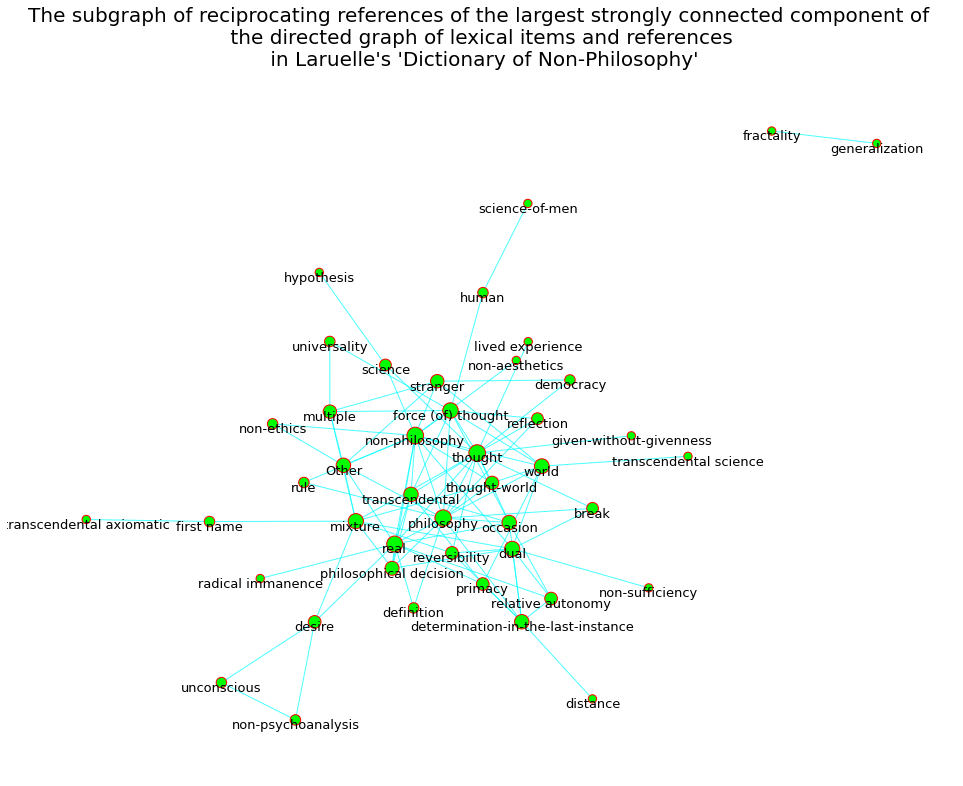

In [37]:
# nsi=[100*math.log(1+G.in_degree(n)) for n in G.nodes()]
nsi=[]
for n in Gr.nodes():
    if Gr.degree(n)>0:
        nsi.append(100*math.log(1+Gr.degree(n)))
    else:
        nsi.append(20)
figsize=(17,13)
pos=graphviz_layout(Gr) 

tweaks = {
    'philosophy': (-5, -10),
    'thought-world': (0, 10),
    'non-ethics': (0, -10),
    'non-philosophy': (0, 15),
    'reversibility': (0, 15),
    'primacy': (0, 10),
    'definition': (0, 15),
    'non-sufficiency': (0, 10),
}

adjust(pos, tweaks)

node_color="lime"
node_border_color="r"
edge_color="cyan"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gr, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gr, pos, edge_color=edge_color,alpha=0.7)
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gr, yoffset,font_size=13);
sst="The subgraph of reciprocating references of the largest strongly connected component of \n the directed graph of lexical items and references \n in %s" %st
plt.title(sst,fontsize=20);
plt.margins(x=0.1, y=0.1) 

In [38]:
graph_data = json_graph.node_link_data(Gr)

In [39]:
order = 'rr'
js_text = js_template.substitute({
    'order': order,
    'graph_data': json.dumps(graph_data),
    'pos_data': json.dumps(pos),
    'arrowsize': 5,
    'edge_type': 'line',
    'node_color': node_color,
    'edge_color': edge_color
})

html_text = html_template.substitute({
    'order': order,
    'title': sst,
    'js_text': js_text
})

HTML(html_text)

In [40]:
f = open('graph%s.html' % order, 'w+')
f.write(scripts + html_text)
f.close()

In [41]:
partition = community.best_partition(Gr)
# print partition

kk=len(set(partition.values()))
modularity=community.modularity(partition, Gr, weight='weight')
print("The reciprocated network of Wikipedia pages of", 'st', "has",
kk, 'communities and modularity coefficient equal to',
modularity,'\n')
# print

cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
# ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
ocmd=sorted(cmd.items(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
louvain_comm_membership={}
for i in eocmd:
    print( 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0]),'\n')
#     print
    commsd[i[0]]=i[1][1]
    ts=list(i[1][0])
    louvain_comm_membership[i[0]]=ts

The reciprocated network of Wikipedia pages of st has 7 communities and modularity coefficient equal to 0.3277800916284881 

Community 0 with 9 nodes: ['non-philosophy', 'world', 'Other', 'non-aesthetics', 'stranger', 'non-ethics', 'thought-world', 'rule', 'transcendental science'] 

Community 1 with 8 nodes: ['dual', 'determination-in-the-last-instance', 'reversibility', 'occasion', 'relative autonomy', 'break', 'distance', 'non-sufficiency'] 

Community 2 with 7 nodes: ['philosophical decision', 'philosophy', 'transcendental', 'definition', 'real', 'radical immanence', 'primacy'] 

Community 3 with 7 nodes: ['reflection', 'thought', 'science', 'given-without-givenness', 'democracy', 'hypothesis', 'lived experience'] 

Community 4 with 6 nodes: ['desire', 'non-psychoanalysis', 'unconscious', 'mixture', 'first name', 'transcendental axiomatic'] 

Community 5 with 5 nodes: ['force (of) thought', 'human', 'multiple', 'universality', 'science-of-men'] 

Community 6 with 2 nodes: ['fractal

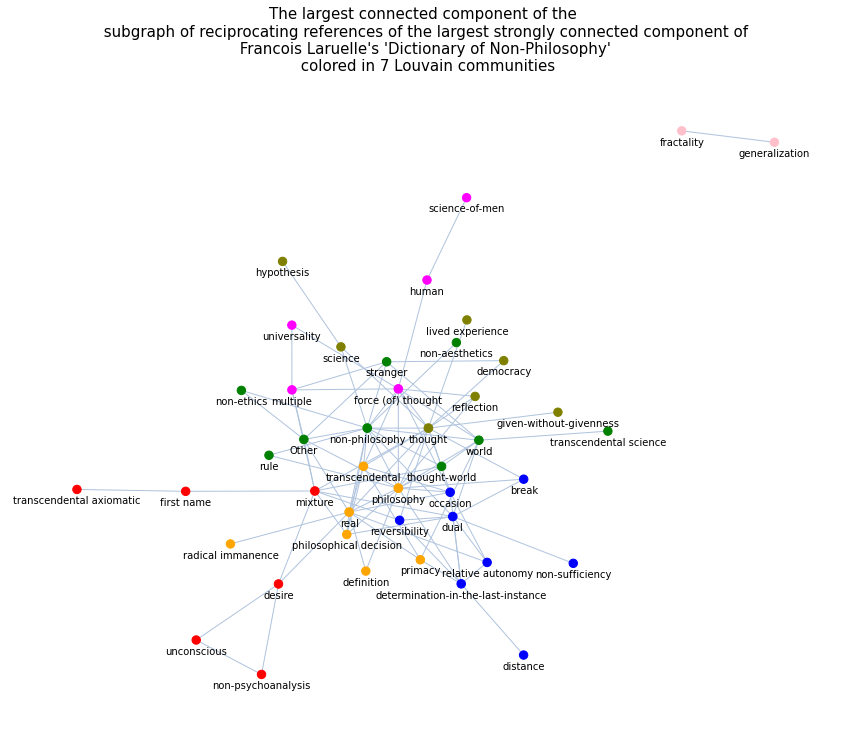

In [42]:
# edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
# # elabels = nx.get_edge_attributes(Gw,'weight')
# edge_width=[math.log(1+w) for w in edge_width]
# # [3*w for w in edge_width]

ccolors = {}
for n in Gr.nodes():
    ccolors[n] = ['red', 'blue', 'green', 'orange', 'magenta', 'olive', 'pink'][partition[n]]

colors_data = ccolors
    
nsi=[]
for n in Gr.nodes():
    nsi.append(Gr.degree(n))
# nsi=[10+0.1*z for z in nsi]
nsi = [70+0.4*z for z in nsi]

figsize=(15,12)
pos=graphviz_layout(Gr)
# node_color="#ffb3b3"
# node_border_color="r"
# edge_color="#668cff"

tweaks = {
    'definition': (0, 15),
    'reversibility': (0, 15),
    'philosophy': (0, -10),
    'thought-world': (5, 0),
    'thought': (5, 0),
    'primacy': (-5, 0),
    'lived experience': (0, 5),
}

adjust(pos, tweaks)

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gr, pos, node_color=ccolors.values(),node_size=nsi)
# nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gr, pos, edge_color='lightsteelblue',alpha=1)
#width=edge_width,
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -10 #0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gr, yoffset,font_size=10);
# sst="The largest connected component of \n the reciprocated network of Wikipedia pages of '%s'" %st
sst="The largest connected component of the \n subgraph of reciprocating references of the largest strongly connected component of \n Francois Laruelle's 'Dictionary of Non-Philosophy' \n colored in %i Louvain communities" % kk
plt.title(sst,fontsize=15)
plt.margins(x=0.1, y=0.1)

In [43]:
graph_data = json_graph.node_link_data(Gr)

In [44]:
js_template1 = Template('''
sigmas.$order = new sigma({
  renderer: {
    container: 'container$order',
    type: 'canvas'
  },
  settings: {
    minArrowSize: 5,
    labelThreshold: 1,
    defaultLabelAlignment: 'bottom'
  }
})

bind1 = S=>{
  let graph = $graph_data
  let pos = $pos_data
  let colors = $node_colors

  let get_neighbors = (id, g)=>{
    let res = {}
    g.nodes().map(n=>{
      if(colors[n.id] == colors[id]){
        res[n.id] = n
      }
    })
    return res
  }

  graph.nodes.map((a, i)=>{
    a.label = a.id
    a.x = pos[a.id][0]
    a.y = pos[a.id][1]
    a.color = colors[a.id]
    a.size = 1
    S.graph.addNode(a)
  })

  graph.links.map((a, i)=>{
    a.id = i
    a.type = '$edge_type'
    a.color = '$edge_color'
    S.graph.addEdge(a)
  })

  S.bind('clickNode', e=>{
    let id = e.data.node.id
    let keep = get_neighbors(id, S.graph)
    keep[id] = e.data.node
  
    S.graph.nodes().forEach(n=>{
      n.color = keep[n.id] ? colors[n.id] : '#eee'
    })
  
    S.graph.edges().forEach(e=>{
      e.color = keep[e.source] && keep[e.target] ? '$edge_color' : 'rgba(238, 238, 238, .3)'
    })
  
    S.refresh()
  })

  S.bind('clickStage', e=>{
    if(!e.data.captor.isDragging){
      S.graph.nodes().forEach(n=>{
        n.color = colors[n.id]
      })

      S.graph.edges().forEach(e=>{
        e.color = '$edge_color'
      })

      S.refresh()
    }
  })

  S.refresh()
}

bind1(sigmas.$order)
''')

In [45]:
order = 'lc'
js_text = js_template1.substitute({
    'order': order,
    'graph_data': json.dumps(graph_data),
    'pos_data': json.dumps(pos),
    'edge_type': 'line',
    'node_colors': json.dumps(colors_data),
    'edge_color': '#668cff'
})

html_text = html_template.substitute({
    'order': order,
    'title': sst,
    'js_text': js_text
})

HTML(html_text)

In [46]:
f = open('graph%s.html' % order, 'w+')
f.write(scripts + html_text)
f.close()

In [47]:
Gl = max(nx.connected_components(Gr), key=len)
Glcc = Gr.subgraph(Gl)

In [48]:
kk=10
fcomms=list(nx.algorithms.community.asyn_fluid.asyn_fluidc(Glcc,kk))
fcolors={}
for k,v in enumerate(fcomms):
    for vv in v:
        fcolors[vv]=tableau_cl[k]
ccolors={n:fcolors[n] for n in list(Glcc.nodes())}

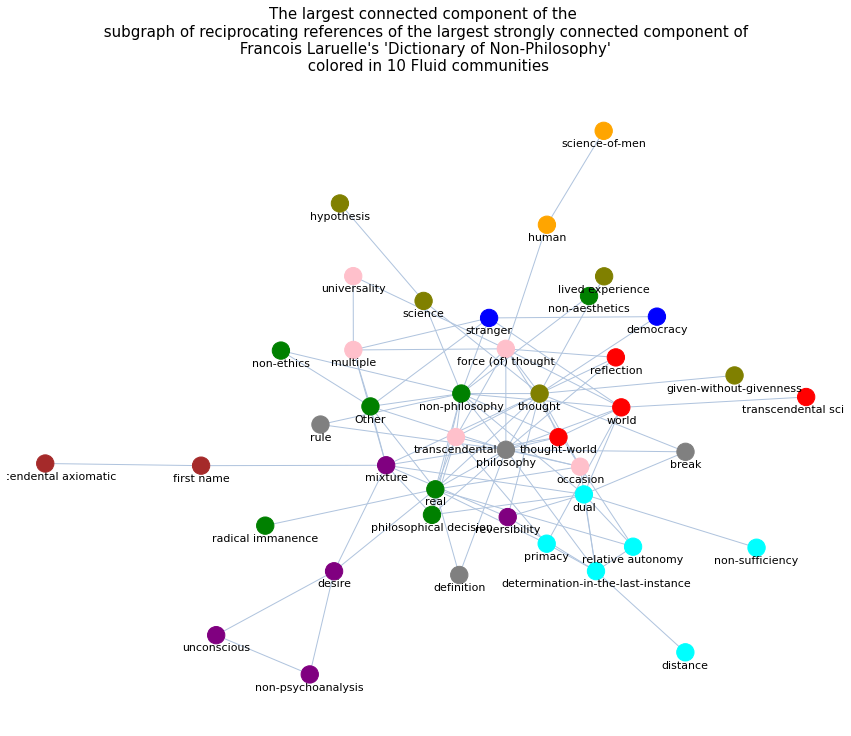

In [49]:
# edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
# # elabels = nx.get_edge_attributes(Gw,'weight')
# edge_width=[math.log(1+w) for w in edge_width]
# # [3*w for w in edge_width]

colors_data = ccolors

nsi=[]
for n in Glcc.nodes():
#     nsi.append(Glcc.degree(n))
    nsi.append(200*math.log(1+Glcc.degree(n)))
# nsi=[7+0.05*z for z in nsi]
# nsi = [70+0.4*z for z in nsi]

figsize=(15,12)
pos=graphviz_layout(Glcc)
# node_color="#ffb3b3"
# node_border_color="r"
# edge_color="#668cff"

plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Glcc, pos,
node_color=ccolors.values())
# nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Glcc, pos, edge_color='lightsteelblue',alpha=1)
#width=edge_width,
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);
plt.axis('off');
yoffset = {}
y_off = -10 #0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Glcc, yoffset,font_size=11);
# sst="The largest connected component of \n the reciprocated network of Wikipedia pages of '%s'" %st
sst="The largest connected component of the \n subgraph of reciprocating references of the largest strongly connected component of \n Francois Laruelle's 'Dictionary of Non-Philosophy' \n colored in %i Fluid communities" % kk
plt.title(sst,fontsize=15);
plt.margins(x=0.05, y=0.1)

In [50]:
graph_data = json_graph.node_link_data(Glcc)

In [51]:
order = 'fc'
js_text = js_template1.substitute({
    'order': order,
    'graph_data': json.dumps(graph_data),
    'pos_data': json.dumps(pos),
    'edge_type': 'line',
    'node_colors': json.dumps(colors_data),
    'edge_color': '#668cff'
})

html_text = html_template.substitute({
    'order': order,
    'title': sst,
    'js_text': js_text
})

HTML(html_text)

In [52]:
f = open('graph%s.html' % order, 'w+')
f.write(scripts + html_text)
f.close()